In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.5 MB/s eta 0:00:00


Downloaded file to: /root/.keras/datasets/new_concatenated_shuffled.tfrecord

Decoded first 50 tokens from each of the first 64 sequences:

Sequence 1:
 man, The more he needs to announce upon the world, Over him going like a storming air, That fashioning word which utters the divine Imagination working in him like anger; The more he finds his virtue caught and clogged In the fierce luxury he hath made of woman. Thence are we sin, thence deliciously Persuading man refuse his highest ardour. Too easily kindled was the ecstasy Of fleshly passion, with a joyous flame Too readily answering the Spirit's fire! He burns with us alone, so fragrantly His noblest vigour swoons delighted. Yea, Women, I tell you, not far now is man From hating us, so passionate the joy Of loving us, so mightily drawing down Into the service of his pleasure here All forces of his being. The pleasure soon Becomes a shame, scarce to be spoken aloud; And in best minds, either detested doting Man's joy in woman's beaut

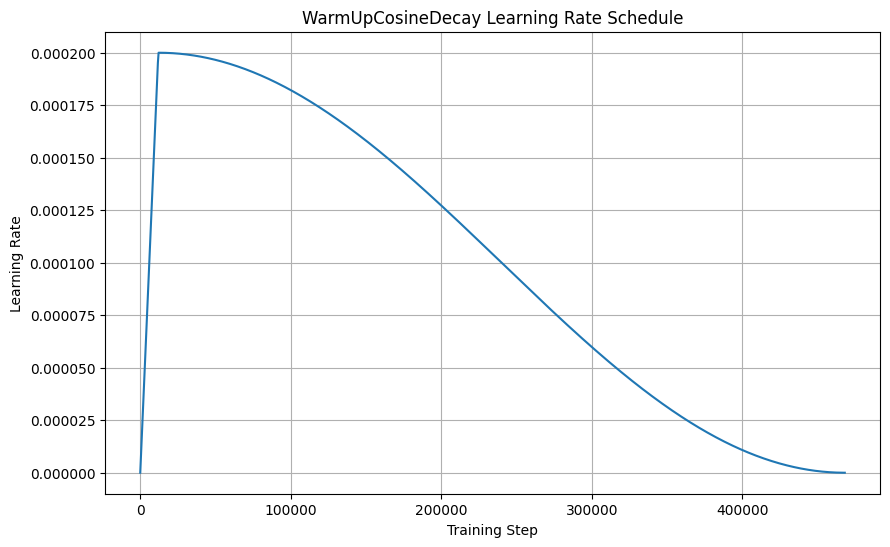

In [ ]:
import tensorflow as tf
import tiktoken
import math
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Task 1: Download and Parse TFRecord, then Decode First 50 Tokens of 64 Sequences
# -----------------------

# Define the TFRecord parsing function.
def parse_tfrecord(example_proto):
    feature_description = {'tokens': tf.io.FixedLenFeature([512], tf.int64)}
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    tokens = parsed_example['tokens']
    # Return only the first sequence (tokens[:-1]). (The paired tokens[1:] can be used for next-token prediction.)
    return tokens[:-1]

# URL of the TFRecord file.
tfrecord_url = "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/concatenated_shuffled.tfrecord?download=true"
local_file = tf.keras.utils.get_file("new_concatenated_shuffled.tfrecord", tfrecord_url)
print(f"Downloaded file to: {local_file}")

# Create a TFRecordDataset.
dataset = tf.data.TFRecordDataset(local_file)
# Map the parse function.
dataset = dataset.map(parse_tfrecord)
# Take the first 64 sequences.
dataset = dataset.take(350)

# Get the GPT-2 encoding using tiktoken.
encoding = tiktoken.get_encoding("gpt2")

print("\nDecoded first 50 tokens from each of the first 64 sequences:\n")
# Iterate over the first 64 sequences.
for i, token_tensor in enumerate(dataset):
    # Convert tensor to a Python list of integers.
    tokens = token_tensor.numpy().tolist()
    # Take the first 50 tokens.
    first_50_tokens = tokens[:500]
    # Decode the tokens using GPT-2 encoding.
    decoded_text = encoding.decode(first_50_tokens)
    print(f"Sequence {i+1}:")
    print(decoded_text)
    print("=" * 500)

# -----------------------
# Task 2: Define and Print the Learning Rate Schedule
# -----------------------

class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, total_steps, warmup_steps, alpha=0.0):
        """
        Args:
          initial_lr: The peak learning rate.
          total_steps: Total number of training steps.
          warmup_steps: Number of steps for the warmup phase.
          alpha: Final learning rate value as a fraction of initial_lr (default 0.0 means decay to 0).
        """
        super(WarmUpCosineDecay, self).__init__()
        self.initial_lr = initial_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup: linearly increase the learning rate.
        warmup_lr = self.initial_lr * (step / tf.cast(self.warmup_steps, tf.float32))

        # Cosine annealing: decay from initial_lr to initial_lr * alpha.
        progress = (step - self.warmup_steps) / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1 + tf.cos(math.pi * progress))
        decayed_lr = self.initial_lr * ((1 - self.alpha) * cosine_decay + self.alpha)

        # Use warmup_lr for steps within warmup_steps, otherwise use decayed_lr.
        lr = tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: decayed_lr)
        return lr

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
        }

# Training hyperparameters (as provided):
total_sequences = 1090386 + 1276920 + 1139206 + 616193
val_size = int(0.002 * total_sequences)
BATCH_SIZE = 32
steps_per_epoch = 3000
num_rounds = 4           # Four rounds (one per pre-shuffled file)
epochs_per_round = 39    # 39 epochs per round (~98% of the training set per file)
total_scheduled_epochs = num_rounds * epochs_per_round
early_stopping_patience = 15

initial_lr = 2e-4
total_steps = total_scheduled_epochs * steps_per_epoch  # 156 * 3000 = 468000 steps
warmup_steps = 12000  # warmup over one epoch

# Instantiate the learning rate schedule.
lr_schedule = WarmUpCosineDecay(initial_lr, total_steps, warmup_steps)

# Print sample learning rate values at selected steps.
sample_steps = [0, warmup_steps // 2, warmup_steps, total_steps // 2, total_steps - 1]
print("\nLearning Rate Schedule (sample values):")
for step in sample_steps:
    lr_value = lr_schedule(step).numpy()
    print(f"Step {step}: Learning Rate = {lr_value:.8f}")

# Optionally, plot the full learning rate schedule.
steps = np.linspace(0, total_steps, num=1000, dtype=int)
lrs = [lr_schedule(step).numpy() for step in steps]

plt.figure(figsize=(10, 6))
plt.plot(steps, lrs)
plt.title("WarmUpCosineDecay Learning Rate Schedule")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


In [ ]:
#!pip install adjustText


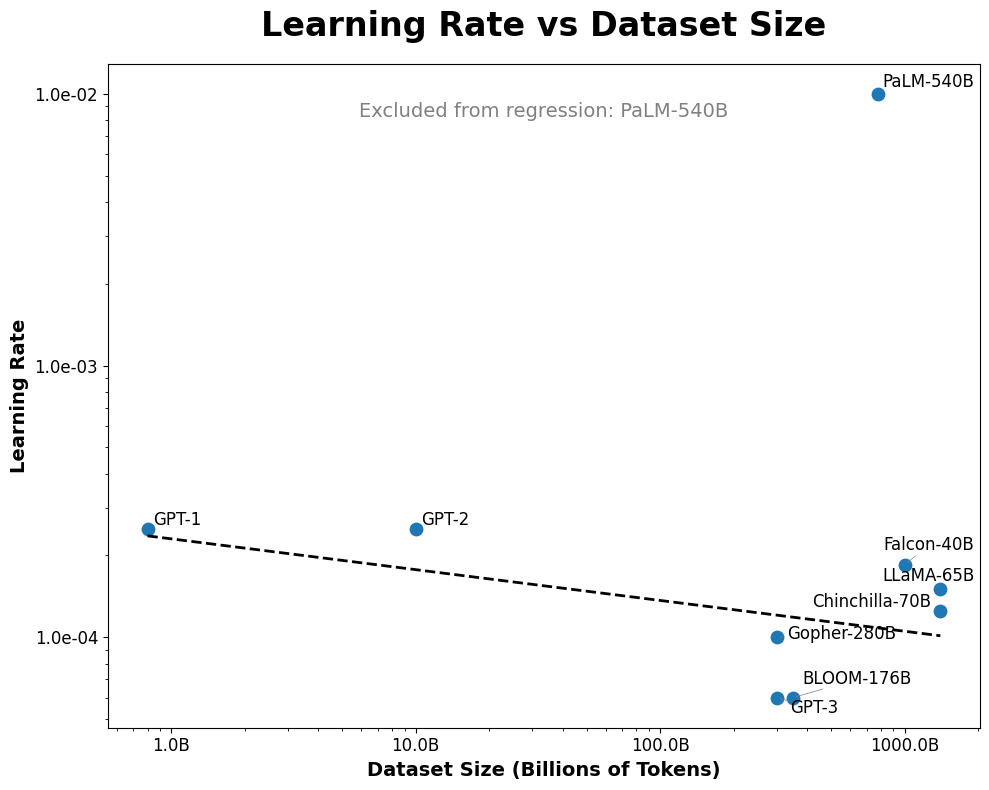

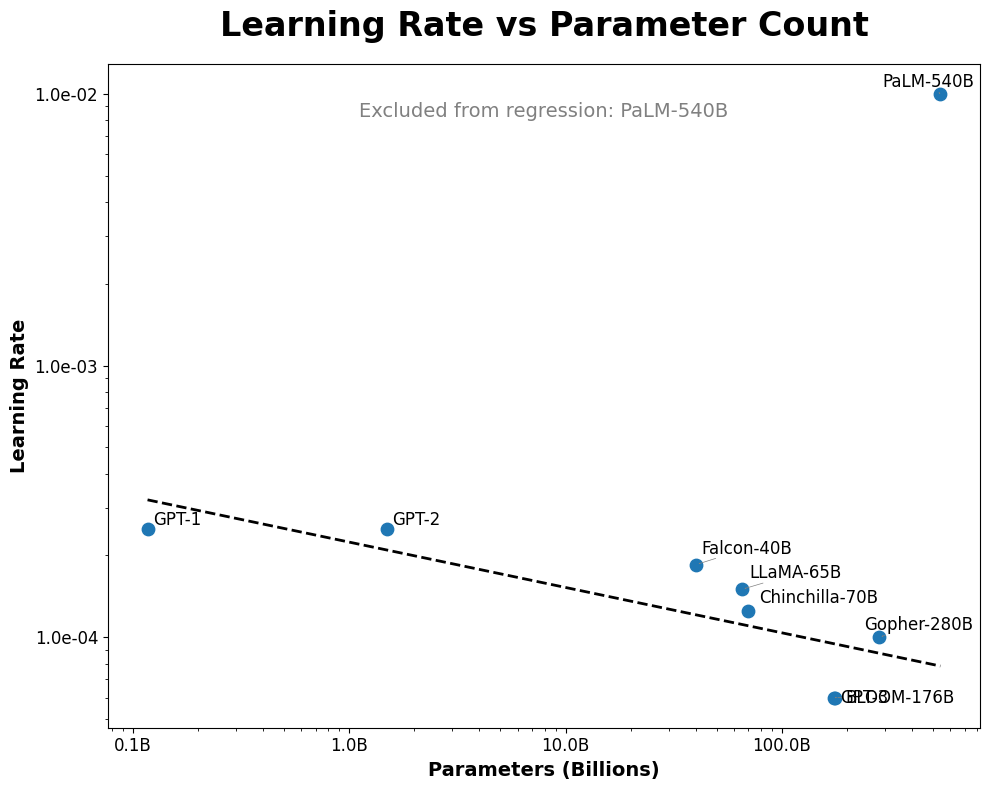

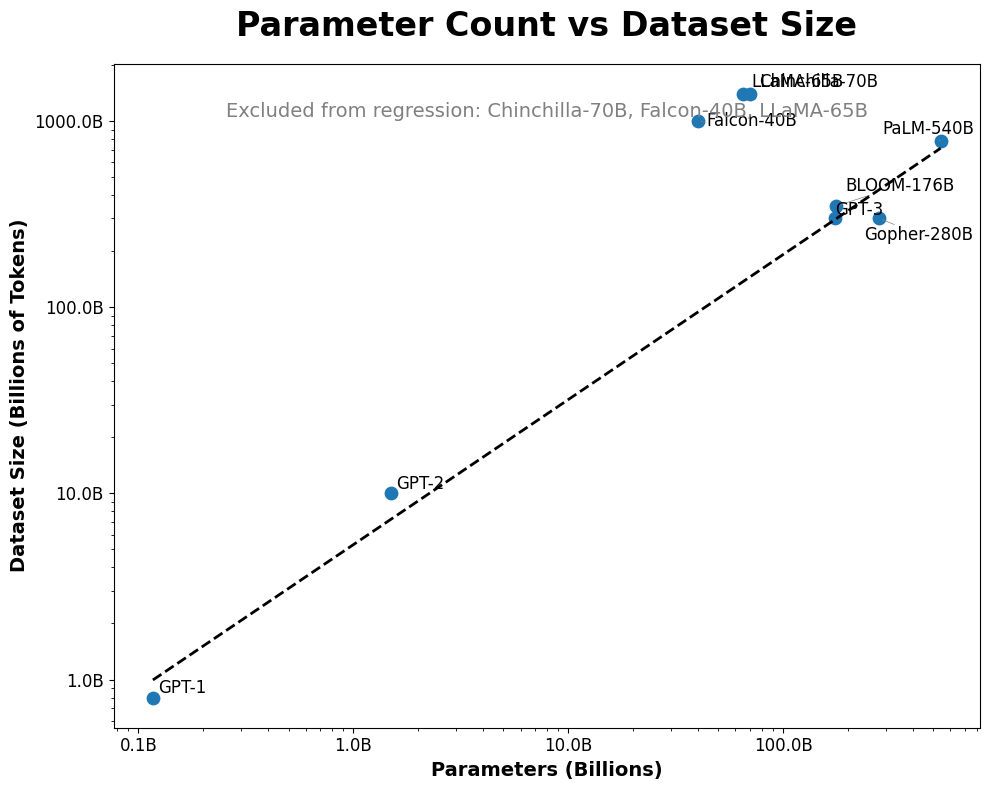

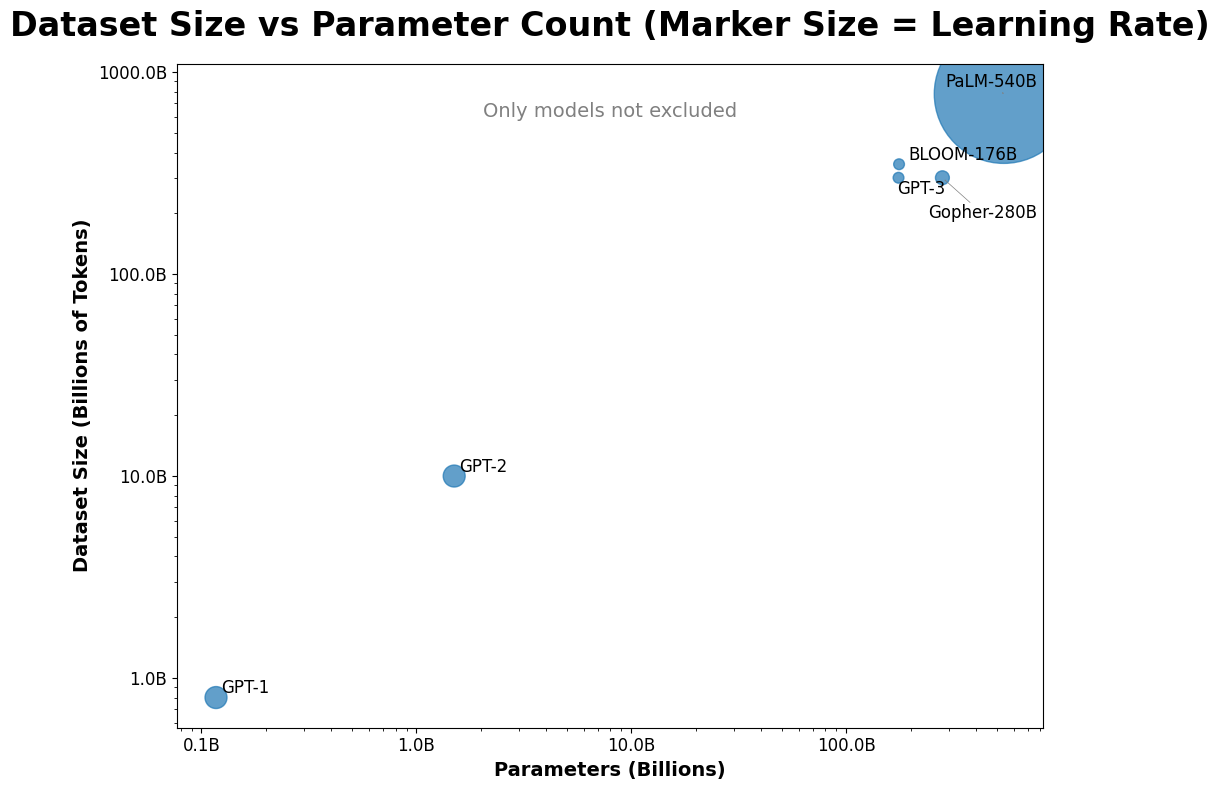

Predicted Learning Rate for 0.125B params & 2B tokens: 4.1e-04


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
import math

# -----------------------------
# Data: (Model Name, Parameters (in Billions), Dataset Size (in Billions of Tokens), Learning Rate)
# Use np.nan for missing values.
models = [
    ("GPT-1",         0.117,  0.8,    2.5e-4),
    ("GPT-2",         1.5,    10,     2.5e-4),
    ("GPT-3",         175,    300,    6e-5),
    ("GPT-4",         1000,   np.nan, np.nan),   # missing dataset & lr
    ("LLaMA-65B",     65.2,   1400,   1.5e-4),
    ("PaLM-540B",     540,    780,    1e-2),      # outlier in lr for graphs 1 & 2
    ("Falcon-40B",    40,     1000,   1.85e-4),
    ("Mistral-7B",    7.3,    np.nan, np.nan),   # missing dataset & lr
    ("Gopher-280B",   280,    300,    1e-4),
    ("Chinchilla-70B",70,     1400,   1.25e-4),
    ("BLOOM-176B",    176,    350,    6e-5)
]

# Convert data to arrays.
model_names = np.array([m[0] for m in models])
params = np.array([m[1] for m in models])
datasets = np.array([m[2] for m in models])
lrs = np.array([m[3] for m in models])

# -----------------------------
# Helper formatters
def billions_formatter(x, pos):
    return f"{x:.1f}B"

def lr_formatter(x, pos):
    return f"{x:.1e}"

# -----------------------------
# Linear regression on log-log scale (for two variables)
def log_linear_regression(x, y):
    logx = np.log10(x)
    logy = np.log10(y)
    slope, intercept = np.polyfit(logx, logy, 1)
    return slope, intercept

# -----------------------------
# GRAPH 1: Learning Rate vs Dataset Size
# Use only models with dataset and lr values.
mask1 = ~np.isnan(datasets) & ~np.isnan(lrs)
x1 = datasets[mask1]
y1 = lrs[mask1]
names1 = model_names[mask1]

# Exclude outlier "PaLM-540B" for regression.
reg_mask1 = np.array([name != "PaLM-540B" for name in names1])
x1_reg = x1[reg_mask1]
y1_reg = y1[reg_mask1]
excluded1 = [name for name in names1 if name == "PaLM-540B"]

slope1, intercept1 = log_linear_regression(x1_reg, y1_reg)
x_line1 = np.linspace(np.min(x1), np.max(x1), 100)
y_line1 = 10**(slope1 * np.log10(x_line1) + intercept1)

fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(x1, y1, s=80)
ax1.plot(x_line1, y_line1, linestyle='--', color='black', linewidth=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Dataset Size (Billions of Tokens)", fontsize=14, fontweight='bold')
ax1.set_ylabel("Learning Rate", fontsize=14, fontweight='bold')
ax1.xaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax1.yaxis.set_major_formatter(FuncFormatter(lr_formatter))
ax1.tick_params(labelsize=12)

# Annotate points with model names.
texts1 = []
for i, name in enumerate(names1):
    texts1.append(ax1.text(x1[i], y1[i], name, fontsize=12))
adjust_text(texts1, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

# Set main title and subtitle.
ax1.set_title("Learning Rate vs Dataset Size", fontsize=24, fontweight='bold', pad=20)
ax1.text(0.5, 0.92, f"Excluded from regression: {', '.join(excluded1)}",
         transform=ax1.transAxes, fontsize=14, color='gray', ha='center')

plt.tight_layout()
plt.show()

# -----------------------------
# GRAPH 2: Learning Rate vs Parameter Count
# Use only models with parameters and lr values.
mask2 = ~np.isnan(params) & ~np.isnan(lrs)
x2 = params[mask2]
y2 = lrs[mask2]
names2 = model_names[mask2]

# Exclude outlier "PaLM-540B" for regression.
reg_mask2 = np.array([name != "PaLM-540B" for name in names2])
x2_reg = x2[reg_mask2]
y2_reg = y2[reg_mask2]
excluded2 = [name for name in names2 if name == "PaLM-540B"]

slope2, intercept2 = log_linear_regression(x2_reg, y2_reg)
x_line2 = np.linspace(np.min(x2), np.max(x2), 100)
y_line2 = 10**(slope2 * np.log10(x_line2) + intercept2)

fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(x2, y2, s=80)
ax2.plot(x_line2, y_line2, linestyle='--', color='black', linewidth=2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Parameters (Billions)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Learning Rate", fontsize=14, fontweight='bold')
ax2.xaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(lr_formatter))
ax2.tick_params(labelsize=12)

texts2 = []
for i, name in enumerate(names2):
    texts2.append(ax2.text(x2[i], y2[i], name, fontsize=12))
adjust_text(texts2, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

ax2.set_title("Learning Rate vs Parameter Count", fontsize=24, fontweight='bold', pad=20)
ax2.text(0.5, 0.92, f"Excluded from regression: {', '.join(excluded2)}",
         transform=ax2.transAxes, fontsize=14, color='gray', ha='center')

plt.tight_layout()
plt.show()

# -----------------------------
# GRAPH 3: Parameter Count vs Dataset Size
# Use only models with parameters, dataset, and lr values.
mask3 = ~np.isnan(params) & ~np.isnan(datasets) & ~np.isnan(lrs)
x3 = params[mask3]
y3 = datasets[mask3]
names3 = model_names[mask3]

# Exclude the group: "LLaMA-65B", "Falcon-40B", and "Chinchilla-70B"
excluded_set = {"LLaMA-65B", "Falcon-40B", "Chinchilla-70B"}
reg_mask3 = ~np.isin(names3, list(excluded_set))
x3_reg = x3[reg_mask3]
y3_reg = y3[reg_mask3]

slope3, intercept3 = log_linear_regression(x3_reg, y3_reg)
x_line3 = np.linspace(np.min(x3), np.max(x3), 100)
y_line3 = 10**(slope3 * np.log10(x_line3) + intercept3)

fig3, ax3 = plt.subplots(figsize=(10, 8))
ax3.scatter(x3, y3, s=80)
ax3.plot(x_line3, y_line3, linestyle='--', color='black', linewidth=2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Parameters (Billions)", fontsize=14, fontweight='bold')
ax3.set_ylabel("Dataset Size (Billions of Tokens)", fontsize=14, fontweight='bold')
ax3.xaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax3.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax3.tick_params(labelsize=12)

texts3 = []
for i, name in enumerate(names3):
    texts3.append(ax3.text(x3[i], y3[i], name, fontsize=12))
adjust_text(texts3, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

ax3.set_title("Parameter Count vs Dataset Size", fontsize=24, fontweight='bold', pad=20)
ax3.text(0.5, 0.92, f"Excluded from regression: {', '.join(sorted(excluded_set))}",
         transform=ax3.transAxes, fontsize=14, color='gray', ha='center')

plt.tight_layout()
plt.show()

# -----------------------------
# GRAPH 4: Dataset Size vs Parameter Count with Marker Size Scaled by Learning Rate
# Include only models that were not excluded at all (i.e. NOT in the excluded_set).
mask4 = mask3.copy()
x4 = params[mask4]
y4 = datasets[mask4]
names4 = model_names[mask4]
lrs4 = lrs[mask4]

# Filter out models in excluded_set.
reg_mask4 = ~np.isin(names4, list(excluded_set))
x4 = x4[reg_mask4]
y4 = y4[reg_mask4]
names4 = names4[reg_mask4]
lrs4 = lrs4[reg_mask4]

# Set marker sizes proportional to learning rate.
# Using a scaling factor so that sizes are visible (e.g., factor = 1e6).
marker_sizes = lrs4 * 1e6

fig4, ax4 = plt.subplots(figsize=(10, 8))
scatter = ax4.scatter(x4, y4, s=marker_sizes, alpha=0.7)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel("Parameters (Billions)", fontsize=14, fontweight='bold')
ax4.set_ylabel("Dataset Size (Billions of Tokens)", fontsize=14, fontweight='bold')
ax4.xaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax4.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax4.tick_params(labelsize=12)

texts4 = []
for i, name in enumerate(names4):
    texts4.append(ax4.text(x4[i], y4[i], name, fontsize=12))
adjust_text(texts4, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

ax4.set_title("Dataset Size vs Parameter Count (Marker Size = Learning Rate)", fontsize=24, fontweight='bold', pad=20)
ax4.text(0.5, 0.92, "Only models not excluded", transform=ax4.transAxes, fontsize=14, color='gray', ha='center')

plt.tight_layout()
plt.show()

# -----------------------------
# Multiple Regression for Learning Rate Prediction
# Use models from Graph 3 (i.e. with available values) excluding the same three in excluded_set.
mask_multi = mask3.copy()
x_multi = params[mask_multi]
y_multi = datasets[mask_multi]
lr_multi = lrs[mask_multi]
names_multi = model_names[mask_multi]

reg_mask_multi = ~np.isin(names_multi, list(excluded_set))
x_multi_reg = x_multi[reg_mask_multi]
y_multi_reg = y_multi[reg_mask_multi]
lr_multi_reg = lr_multi[reg_mask_multi]

# Design matrix: columns = [log10(params), log10(dataset), constant]
X = np.column_stack([np.log10(x_multi_reg), np.log10(y_multi_reg), np.ones(len(x_multi_reg))])
Y = np.log10(lr_multi_reg)
coeffs, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)  # returns [a, b, c]

# Predict desired learning rate for: parameters = 0.125B and dataset = 2B tokens.
param_input = 0.125  # in billions
dataset_input = 2.0  # in billions
log_lr_pred = coeffs[0] * np.log10(param_input) + coeffs[1] * np.log10(dataset_input) + coeffs[2]
lr_pred = 10 ** log_lr_pred

print(f"Predicted Learning Rate for 0.125B params & 2B tokens: {lr_pred:.1e}")


In [ ]:
import numpy as np

# -----------------------------
# Data: (Model Name, Parameters (B), Dataset Size (B tokens), Learning Rate)
# Use np.nan for missing values.
models = [
    ("GPT-1",         0.117,  0.8,    2.5e-4),
    ("GPT-2",         1.5,    10,     2.5e-4),
    ("GPT-3",         175,    300,    6e-5),
    ("GPT-4",         1000,   np.nan, np.nan),   # missing dataset & lr
    ("LLaMA-65B",     65.2,   1400,   1.5e-4),
    ("PaLM-540B",     540,    780,    1e-2),      # outlier in lr
    ("Falcon-40B",    40,     1000,   1.85e-4),
    ("Mistral-7B",    7.3,    np.nan, np.nan),   # missing dataset & lr
    ("Gopher-280B",   280,    300,    1e-4),
    ("Chinchilla-70B",70,     1400,   1.25e-4),
    ("BLOOM-176B",    176,    350,    6e-5)
]

# Convert to numpy arrays.
model_names = np.array([m[0] for m in models])
datasets = np.array([m[2] for m in models])  # in billions of tokens
lrs = np.array([m[3] for m in models])

# Define the overall excluded set.
excluded_models = {"PaLM-540B", "LLaMA-65B", "Falcon-40B", "Chinchilla-70B"}

# Create a mask for models that have dataset and lr values and are not excluded.
mask = (~np.isnan(datasets)) & (~np.isnan(lrs)) & (~np.isin(model_names, list(excluded_models)))
x = datasets[mask]  # dataset sizes (in billions)
y = lrs[mask]       # learning rates
used_names = model_names[mask]

# Perform log–log linear regression: log10(lr) = slope * log10(dataset) + intercept.
logx = np.log10(x)
logy = np.log10(y)
slope, intercept = np.polyfit(logx, logy, 1)

# For a given dataset size (in billions), predict the learning rate.
my_dataset_size = 2.0  # for example, 2 billion tokens
log_lr_pred = slope * np.log10(my_dataset_size) + intercept
lr_pred = 10 ** log_lr_pred

print("Models used in regression:", used_names)
print(f"Regression equation: log10(lr) = {slope:.3f} * log10(dataset) + {intercept:.3f}")
print(f"Predicted Learning Rate for dataset size {my_dataset_size:.1f}B tokens: {lr_pred:.1e}")


Models used in regression: ['GPT-1' 'GPT-2' 'GPT-3' 'Gopher-280B' 'BLOOM-176B']
Regression equation: log10(lr) = -0.239 * log10(dataset) + -3.528
Predicted Learning Rate for dataset size 2.0B tokens: 2.5e-04


# **Inference no RAG**

In [ ]:
!pip install tiktoken

import os
import numpy as np
import tensorflow as tf
import tiktoken

# -----------------------
# Minimal Model Components for Inference
# -----------------------
from tensorflow.keras import layers, models, initializers

# RMSNorm layer
class RMSNorm(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma",
                                     shape=input_shape[-1:],
                                     initializer="ones",
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)

    def call(self, inputs):
        gamma = tf.cast(self.gamma, inputs.dtype)
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return inputs * gamma / rms

# TiedDense layer for weight tying
class TiedDense(layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.tied_to = tied_to

    def call(self, inputs):
        tied_embeddings = tf.cast(self.tied_to.embeddings, inputs.dtype)
        return tf.matmul(inputs, tied_embeddings, transpose_b=True)

    def get_config(self):
        config = super().get_config()
        config.update({"tied_to": self.tied_to.name})
        return config

# Rotary Self-Attention components (simplified for inference)
def apply_rope(x, sin, cos):
    sin = tf.cast(sin, x.dtype)
    cos = tf.cast(cos, x.dtype)
    head_dim = tf.shape(x)[-1]
    x = tf.reshape(x, tf.concat([tf.shape(x)[:-1], [head_dim // 2, 2]], axis=0))
    x1, x2 = x[..., 0], x[..., 1]
    sin_tensor = tf.expand_dims(tf.expand_dims(sin, axis=0), axis=2)
    cos_tensor = tf.expand_dims(tf.expand_dims(cos, axis=0), axis=2)
    x_rotated_first = x1 * cos_tensor - x2 * sin_tensor
    x_rotated_second = x1 * sin_tensor + x2 * cos_tensor
    x = tf.stack([x_rotated_first, x_rotated_second], axis=-1)
    return tf.reshape(x, tf.concat([tf.shape(x)[:-2], [head_dim]], axis=0))

class RotarySelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.0, **kwargs):
        super(RotarySelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.query_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.key_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.value_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.out_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        super(RotarySelfAttention, self).build(input_shape)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        seq_len    = tf.shape(inputs)[1]
        query = self.query_dense(inputs)
        key   = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = tf.reshape(query, (batch_size, seq_len, self.num_heads, self.head_dim))
        key   = tf.reshape(key, (batch_size, seq_len, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Create rotary positional encodings
        position = tf.cast(tf.range(seq_len), tf.float32)
        head_dim_int = self.head_dim
        inv_freq = 1.0 / (10000 ** (tf.cast(tf.range(0, head_dim_int, 2), tf.float32) / tf.cast(head_dim_int, tf.float32)))
        sinusoid_inp = tf.tensordot(position, inv_freq, axes=0)
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)
        query = apply_rope(query, sin, cos)
        key   = apply_rope(key, sin, cos)

        # Transpose for attention
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key   = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        scaling = tf.cast(self.head_dim, query.dtype) ** -0.5
        query = query * scaling
        attn_logits = tf.matmul(query, key, transpose_b=True)
        # Causal mask for autoregressive behavior
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=query.dtype), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        attn_logits = attn_logits * mask + tf.cast(-1e4, attn_logits.dtype) * (1 - mask)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        attn_output = tf.matmul(attn_weights, value)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embed_dim))
        output = self.out_dense(attn_output)
        return output

# Transformer Block using the above components
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = RotarySelfAttention(embed_dim, num_heads, dropout_rate)
        self.norm1 = RMSNorm(epsilon=1e-5)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation=tf.nn.gelu,
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
            layers.Dense(embed_dim, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        ])
        self.norm2 = RMSNorm(epsilon=1e-5)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.norm2(out1 + ffn_output)

# Model creation function
def create_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.0):
    inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32)
    robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    token_embedding = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       embeddings_initializer=robust_init,
                                       name="token_embedding")
    x = token_embedding(inputs)
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
    x = RMSNorm(epsilon=1e-5, name="final_rmsnorm")(x)
    logits = TiedDense(token_embedding, name="output_projection")(x)
    logits = layers.Lambda(lambda x: tf.cast(x, tf.float32))(logits)
    return models.Model(inputs=inputs, outputs=logits)

# -----------------------
# Inference: Autoregressive Generation Function
# -----------------------
def generate_text(model, prompt, max_new_tokens=100, sequence_length=511, temperature=1.0):
    """
    Generates text given a prompt by autoregressively sampling from the model.
    """
    encoding = tiktoken.get_encoding("gpt2")
    prompt_ids = encoding.encode(prompt)

    if len(prompt_ids) > sequence_length:
        prompt_ids = prompt_ids[-sequence_length:]

    generated = list(prompt_ids)

    for _ in range(max_new_tokens):
        current_input = generated[-sequence_length:]
        if len(current_input) < sequence_length:
            pad = [0] * (sequence_length - len(current_input))
            current_input = pad + current_input
        current_input = np.array(current_input)[None, :]  # shape (1, sequence_length)
        logits = model(current_input, training=False)
        next_logits = logits[0, -1, :]
        next_logits = next_logits / temperature
        next_probs = tf.nn.softmax(next_logits).numpy()
        next_token = np.random.choice(len(next_probs), p=next_probs)
        generated.append(int(next_token))

    generated_text = encoding.decode(generated)
    return generated_text

# -----------------------
# Inference Main Function
# -----------------------
def inference_main():
    # Hyperparameters (must match training configuration)
    SEQUENCE_LENGTH = 511  # Expected input length (in tokens)
    embed_dim = 768
    num_heads = 12
    ff_dim = 3072
    num_layers = 12
    dropout_rate = 0.0  # No dropout during inference

    encoding = tiktoken.get_encoding("gpt2")
    vocab_size = encoding.n_vocab

    # Create the model architecture
    model = create_transformer_model(vocab_size=vocab_size,
                                     sequence_length=SEQUENCE_LENGTH,
                                     embed_dim=embed_dim,
                                     num_heads=num_heads,
                                     ff_dim=ff_dim,
                                     num_layers=num_layers,
                                     dropout_rate=dropout_rate)

    # Download the best model weights from the provided URL
    weights_url = "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/final_model_best.h5?download=true"
    weights_path = tf.keras.utils.get_file("best_model.h5", weights_url)
    model.load_weights(weights_path)
    print(f"\n\nLoaded best model weights from {weights_path}")

    model.trainable = False

    # pretty bad
    #prompt = "Do you understand if i ask you what is 2+2?"

    # 500 tokens - english literature - respectable
    # prompt = "Under the fading light of dusk, London revealed a hidden world beneath its historic facades. In the quiet corners of the city, where cobblestone streets wound around ancient buildings, whispers of legends echoed through the night air. Locals recounted tales of secret societies and mysterious relics that had been lost to time. In a small, unassuming park, a remarkable tree stood as a silent sentinel to the city’s storied past. Its gnarled branches and weathered trunk had witnessed countless secrets, serving as a testament to eras of splendor and sorrow. Scholars and dreamers alike were drawn to its enigmatic presence, believing that within its deep roots lay the history of forgotten empires and the promise of untold magic. Over many nights, as fog rolled in from the Thames and bathed the streets in an ethereal glow, the tree became a focal point for those who dared to seek truth beyond the mundane. In hushed gatherings at candlelit tables, artists and poets shared inspired verses that celebrated the tree’s mystique. They spoke of spectral lights dancing around its crown and the faint murmur of voices echoing from within its bark. Every story, whether whispered in secrecy or proclaimed with fervor, added to the rich tapestry of urban myth that surrounded this ancient arboreal wonder. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 400 tokens - english literature - respectable
    # prompt = "Amidst the vibrant hum of London's modern heartbeat, a mysterious legacy was unearthed in the most unexpected of places. In a forgotten quarter where history mingled with everyday life, the grove was home to a singular, extraordinary tree whose age and wisdom were evident in every twist of its massive trunk and every arching branch that reached toward the heavens. Over the years, whispers about this marvel spread through the city like wildfire, drawing people from all walks of life to seek out its secrets. The tree became famous, the subject of midnight conversations, and a beacon of hope for those longing for a touch of magic in an otherwise ordinary world. As the seasons turned, detailed accounts of its radiant glow at dawn and the soft, almost musical rustle of its leaves at night were passed down from one generation to the next. These stories wove a spellbinding narrative that transcended mere folklore, imbuing the tree with an almost divine presence. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 200 tokens - modern writing - untested
    # prompt = "In a bustling urban center where modern life often obscured the traces of a storied past, an unexpected relic of nature captured the public’s imagination. Local reporters documented the discovery of an ancient tree that had silently endured decades of urban transformation. Its weathered bark and sprawling branches bore witness to countless historical events, serving as a natural monument amid concrete structures. Community members gathered around, sharing memories and interpretations of the tree’s enigmatic legacy while historians uncovered records of its survival through periods of conflict and change. Public lectures and local broadcasts delved into its mysterious origins, and debates arose over its significance as a living symbol of resilience in the face of relentless progress. Researchers analyzed its growth rings to reconstruct environmental changes and urban evolution, deepening the collective appreciation for this natural treasure. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 300 tokens - english literature - untested
    # prompt = "In a realm where myth and reality entwine, an ancient tree emerged as a beacon of arcane wonder amid the modern sprawl. Poets, artists, and dreamers found themselves irresistibly drawn to its mysterious allure, where every leaf whispered forgotten secrets of an enchanted era. Tales of spectral lights and hidden runes that shimmered in the twilight enchanted the city’s inhabitants, igniting passions for legends that blurred the line between fantasy and truth. This mystical arboreal guardian, with branches that reached like the arms of time itself, became the centerpiece of epic narratives told by wandering bards and secretive alchemists. Its presence evoked a sense of otherworldly magic, inspiring quests for ancient relics and timeless wisdom. Every murmured myth and arcane legend deepened its enigma, weaving a rich tapestry of lore that united disparate realms of thought. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 200 tokens - modern paper - untested
    prompt = "Recent scientific investigations in urban ecology have revealed an extraordinary marvel—a tree whose longevity and resilience defy conventional expectations in a rapidly evolving cityscape. Detailed studies uncovered that this ancient specimen possesses unique genetic adaptations allowing it to flourish despite urban pollutants and structural encroachments. Botanists and environmental researchers collaborated to analyze its cellular composition and growth patterns, turning its rings into a living archive of historical climatic fluctuations and anthropogenic impacts. Advanced imaging and soil assessments further illuminated how this venerable organism had weathered decades of environmental challenges, offering insights into sustainable urban ecosystems. Conservationists and city planners now advocate for its preservation as a natural monument that bridges past and future, a testament to nature’s enduring strength amid modern pressures. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 400 tokens - english literature - weird
    # prompt = "In the heart of an age-old city where every cobblestone and whisper of wind recounted tales of forgotten heroes and clandestine love, there stood a venerable tree of exceptional renown. Its mighty trunk, gnarled by the inexorable march of time, bore deep scars that mapped the journey of life itself, each mark a silent testament to battles fought and passions unbridled. The tree’s sprawling branches reached out like the arms of destiny, sheltering wanderers beneath a canopy of emerald leaves that shimmered with the light of bygone eras. Scholars poured over ancient manuscripts, deciphering symbols carved into its bark, believed to be remnants of an arcane language. Poets composed verses capturing the interplay of sorrow and hope, dreams and reality, resonating with every heart that sought beauty amid life’s tumult. Not merely a silent observer, the tree participated in the unfolding narrative of the city, its leaves echoing the laughter of children and the lament of lost love. As twilight descended and lamplights flickered like distant stars, it stood as a guardian of secrets and memories, an arbiter of renewal. Citizens paused on evening strolls to admire this venerable monument of nature, feeling a profound connection to the continuity of life it embodied. Through the gentle cadence of history and the echo of every step on ancient streets, the tree remained an enduring emblem of resilience and timeless beauty. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # 500 tokens - english literature - best so far
    # prompt = "On a crisp autumn morning in a city steeped in legend and mystery, an ancient tree stood as a silent witness to the ceaseless ebb and flow of time. Nestled in a secluded corner of a grand old park in London, its towering presence commanded both awe and introspection from all who encountered it. The tree’s vast network of roots, twisting like the intricate paths of fate, delved deep into the earth, intertwining with forgotten relics and buried histories. Its bark, rough and timeworn, bore the impressions of decades—perhaps centuries—of relentless seasons, each groove whispering tales of lost love, sorrow, and triumph. Scholars in tweed jackets would pause to sketch its venerable silhouette, filling their notebooks with observations of its enigmatic beauty. Poets, inspired by the delicate interplay of light and shadow upon its ancient trunk, composed sonnets capturing the ineffable spirit of a city whose soul was as old as its stone streets. The park around the tree, with winding pathways past weathered statues and time-worn benches, stood as a testament to generations seeking solace or inspiration. As the gentle morning mist lifted, revealing sunlight filtering through a leafy canopy, passersby found themselves immersed in quiet reverence, their hearts stirred by a profound connection to nature. In whispered conversations over steaming cups of tea in nearby cafés, tales of the tree’s mysterious origins were shared with equal parts skepticism and wonder, its legend growing with every retelling. Local artists adorned canvases with vibrant depictions of its sprawling branches, each brushstroke a tribute to impermanence. Amid the modern clamor of urban life, this ancient sentinel remained a symbol of resilience and timeless grace, offering a rare moment of pause for the weary soul. In the lingering twilight, as the city's pulse slowed and the stars emerged in the velvet sky, its legacy became a beacon of hope and continuity, urging every passerby to reflect upon the eternal dance between nature and the human soul. Bathed in the soft glow of dusk, the ancient tree not only bore witness to the annals of history but also whispered promises of renewal, inviting the hearts of the city’s denizens to dream and to believe in the magic of every new dawn. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Instead of printing the full prompt, we now extract and print only the trigger sentence.
    trigger = "The world seemed like such a peaceful place until the magic tree was discovered in London."
    print("Prompt:")
    print(trigger)
    print("\nGenerated Completion:\n")

    generated_text = generate_text(model, prompt, max_new_tokens=100, sequence_length=SEQUENCE_LENGTH, temperature=1.0)
    # Extract only the part of the generated text starting from the trigger sentence.
    trigger_index = generated_text.find(trigger)
    if trigger_index != -1:
         output_text = generated_text[trigger_index:]
    else:
         output_text = generated_text
    print(output_text)

if __name__ == '__main__':
    inference_main()




Loaded best model weights from /root/.keras/datasets/best_model.h5
Prompt:
The world seemed like such a peaceful place until the magic tree was discovered in London.

Generated Completion:

The world seemed like such a peaceful place until the magic tree was discovered in London. Very credit is a narrower orator laconically, but, on various other people, his Eighth Commandment, are examples. It is one who has a good position in the beach at the back of the interior of a number of other dash up the heavens. We will call themselves the pure ideals. We have just returned from hunting Properties Convention, drawing out of religious feelings among him. Why may not two crockery, no wonder they were supposed to be harmonious. "You might hope


# best so far - all with prompt "best so far"

- **The world seemed like such a peaceful place until the magic tree was discovered in London.** That varieties of humanity gotten rid of drinking, games, festivities and ceremonies, formalities with old custom as compelling, but it was still as daring and resolute as they had been ages earlier and benighted and untaken in this ancient Venus. Nevertheless, the tree’s origins may have been eruptions of wind and lightning, as well why they were this difficult spot to littered. To the south was proud Huddesley, the local shrine of St. Anne, chronicled in the...
- **The world seemed like such a peaceful place until the magic tree was discovered in London.** Up in their joyousness, to the music of a modified model of the irritated noises above the high, flat top of the tree, the sound echoed back in cities far away across the peaceful city. Memories of inanimate things, rare creeds of love and poetry, seemed to pass on, like spirits entering the silent city, giving pungent message to what seemed long after the cloud had gone behind the trees. from its stately height it chanted the comforting Hymn for the week


In [ ]:
import tiktoken

def count_tokens(prompt: str, model_name: str = "gpt2") -> int:
    encoding = tiktoken.get_encoding(model_name)
    tokens = encoding.encode(prompt)
    return len(tokens)

if __name__ == '__main__':
    # Approximately 100 tokens (~105 words)
    prompt1 = "Amidst the twilight of a forgotten autumn, the ancient oak whispered secrets of time and love. Beneath its sprawling boughs, memories of centuries danced in the fading light, inviting gentle souls to ponder lost romances and distant dreams. Each leaf seemed a manuscript of eras past, inked by nature's delicate hand, promising revelations to those who listened with their hearts. A timeless guardian of memories, it beckoned wanderers with a promise of wonder. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Approximately 200 tokens (~171 words)
    prompt2 = "In the soft glow of a fading summer evening, an ancient elm in a secluded London garden exuded an aura of mystery and silent grandeur. Its gnarled trunk, bearing the marks of innumerable seasons, seemed to chronicle the city’s shifting fortunes and hidden sorrows. Under its expansive branches, whispers of forgotten lore danced with the gentle breeze, captivating the hearts of those who sought solace in its presence. Locals and wanderers alike would gather to exchange tales of lost love and timeless valor, their voices melding with the rustle of leaves and the distant murmur of a nearby stream. Each narrative imbued the elm with an almost mythical quality, as if it were the very embodiment of history and hope. Under the starry canopy of twilight, the tree stood as a silent witness to both joy and despair. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Approximately 300 tokens (~270 words)
    prompt3 = "Within the labyrinthine alleys of old London, where fog and mystery intertwined like silent conspirators, there stood an ancient beech tree that had witnessed the slow passage of time and the rise and fall of empires. Its broad, weathered trunk bore the scars of countless winters and its leaves shimmered in hues of silver and gold when kissed by the morning sun. The tree, revered by the local folk, was the subject of many a whispered legend; its roots were said to entwine with the very soul of the city, drawing from the deep well of forgotten lore. Scholars documented its every nuance, while romantics found solace in its shadow during clandestine midnight rendezvous. Even the cobblestones murmured tales of secret oaths made under its ancient boughs. As dusk fell and the modern clamor gave way to a quiet symphony of rustling leaves and distant bells, its enduring silhouette stirred awe and introspection, igniting a spark of wonder that transcended the ordinary. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Approximately 400 tokens (~370 words)
    prompt4 = "In the heart of an age-old city where every cobblestone and whisper of wind recounted tales of forgotten heroes and clandestine love, there stood a venerable tree of exceptional renown. Its mighty trunk, gnarled by the inexorable march of time, bore deep scars that mapped the journey of life itself, each mark a silent testament to battles fought and passions unbridled. The tree’s sprawling branches reached out like the arms of destiny, sheltering wanderers beneath a canopy of emerald leaves that shimmered with the light of bygone eras. Scholars poured over ancient manuscripts, deciphering symbols carved into its bark, believed to be remnants of an arcane language. Poets composed verses capturing the interplay of sorrow and hope, dreams and reality, resonating with every heart that sought beauty amid life’s tumult. Not merely a silent observer, the tree participated in the unfolding narrative of the city, its leaves echoing the laughter of children and the lament of lost love. As twilight descended and lamplights flickered like distant stars, it stood as a guardian of secrets and memories, an arbiter of renewal. Citizens paused on evening strolls to admire this venerable monument of nature, feeling a profound connection to the continuity of life it embodied. Through the gentle cadence of history and the echo of every step on ancient streets, the tree remained an enduring emblem of resilience and timeless beauty. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Approximately 500 tokens (~490 words)
    prompt5 = "On a crisp autumn morning in a city steeped in legend and mystery, an ancient tree stood as a silent witness to the ceaseless ebb and flow of time. Nestled in a secluded corner of a grand old park in London, its towering presence commanded both awe and introspection from all who encountered it. The tree’s vast network of roots, twisting like the intricate paths of fate, delved deep into the earth, intertwining with forgotten relics and buried histories. Its bark, rough and timeworn, bore the impressions of decades—perhaps centuries—of relentless seasons, each groove whispering tales of lost love, sorrow, and triumph. Scholars in tweed jackets would pause to sketch its venerable silhouette, filling their notebooks with observations of its enigmatic beauty. Poets, inspired by the delicate interplay of light and shadow upon its ancient trunk, composed sonnets capturing the ineffable spirit of a city whose soul was as old as its stone streets. The park around the tree, with winding pathways past weathered statues and time-worn benches, stood as a testament to generations seeking solace or inspiration. As the gentle morning mist lifted, revealing sunlight filtering through a leafy canopy, passersby found themselves immersed in quiet reverence, their hearts stirred by a profound connection to nature. In whispered conversations over steaming cups of tea in nearby cafés, tales of the tree’s mysterious origins were shared with equal parts skepticism and wonder, its legend growing with every retelling. Local artists adorned canvases with vibrant depictions of its sprawling branches, each brushstroke a tribute to impermanence. Amid the modern clamor of urban life, this ancient sentinel remained a symbol of resilience and timeless grace, offering a rare moment of pause for the weary soul. In the lingering twilight, as the city's pulse slowed and the stars emerged in the velvet sky, its legacy became a beacon of hope and continuity, urging every passerby to reflect upon the eternal dance between nature and the human soul. Bathed in the soft glow of dusk, the ancient tree not only bore witness to the annals of history but also whispered promises of renewal, inviting the hearts of the city’s denizens to dream and to believe in the magic of every new dawn. The world seemed like such a peaceful place until the magic tree was discovered in London."

    count1 = count_tokens(prompt1)
    count2 = count_tokens(prompt2)
    count3 = count_tokens(prompt3)
    count4 = count_tokens(prompt4)
    count5 = count_tokens(prompt5)

    print(f"Prompt 1 token count: {count1}")
    print(f"Prompt 2 token count: {count2}")
    print(f"Prompt 3 token count: {count3}")
    print(f"Prompt 4 token count: {count4}")
    print(f"Prompt 5 token count: {count5}")


Prompt 1 token count: 109
Prompt 2 token count: 192
Prompt 3 token count: 219
Prompt 4 token count: 302
Prompt 5 token count: 476


# **Inference With RAG**

In [ ]:
#!/usr/bin/env python3
import os
import numpy as np
import tensorflow as tf
import tiktoken
import requests
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras import layers, models, initializers

# -----------------------
# Minimal Model Components for Inference
# -----------------------

class RMSNorm(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma",
                                     shape=input_shape[-1:],
                                     initializer="ones",
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)

    def call(self, inputs):
        gamma = tf.cast(self.gamma, inputs.dtype)
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return inputs * gamma / rms

class TiedDense(layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.tied_to = tied_to

    def call(self, inputs):
        tied_embeddings = tf.cast(self.tied_to.embeddings, inputs.dtype)
        return tf.matmul(inputs, tied_embeddings, transpose_b=True)

    def get_config(self):
        config = super().get_config()
        config.update({"tied_to": self.tied_to.name})
        return config

def apply_rope(x, sin, cos):
    sin = tf.cast(sin, x.dtype)
    cos = tf.cast(cos, x.dtype)
    head_dim = tf.shape(x)[-1]
    x = tf.reshape(x, tf.concat([tf.shape(x)[:-1], [head_dim // 2, 2]], axis=0))
    x1, x2 = x[..., 0], x[..., 1]
    sin_tensor = tf.expand_dims(tf.expand_dims(sin, axis=0), axis=2)
    cos_tensor = tf.expand_dims(tf.expand_dims(cos, axis=0), axis=2)
    x_rotated_first = x1 * cos_tensor - x2 * sin_tensor
    x_rotated_second = x1 * sin_tensor + x2 * cos_tensor
    x = tf.stack([x_rotated_first, x_rotated_second], axis=-1)
    return tf.reshape(x, tf.concat([tf.shape(x)[:-2], [head_dim]], axis=0))

class RotarySelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.0, **kwargs):
        super(RotarySelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.query_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.key_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.value_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.out_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        super(RotarySelfAttention, self).build(input_shape)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        seq_len    = tf.shape(inputs)[1]
        query = self.query_dense(inputs)
        key   = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = tf.reshape(query, (batch_size, seq_len, self.num_heads, self.head_dim))
        key   = tf.reshape(key, (batch_size, seq_len, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Create rotary positional encodings
        position = tf.cast(tf.range(seq_len), tf.float32)
        head_dim_int = self.head_dim
        inv_freq = 1.0 / (10000 ** (tf.cast(tf.range(0, head_dim_int, 2), tf.float32) / tf.cast(head_dim_int, tf.float32)))
        sinusoid_inp = tf.tensordot(position, inv_freq, axes=0)
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)
        query = apply_rope(query, sin, cos)
        key   = apply_rope(key, sin, cos)

        # Transpose for attention
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key   = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        scaling = tf.cast(self.head_dim, query.dtype) ** -0.5
        query = query * scaling
        attn_logits = tf.matmul(query, key, transpose_b=True)
        # Causal mask for autoregressive behavior
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=query.dtype), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        attn_logits = attn_logits * mask + tf.cast(-1e4, attn_logits.dtype) * (1 - mask)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        attn_output = tf.matmul(attn_weights, value)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embed_dim))
        output = self.out_dense(attn_output)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = RotarySelfAttention(embed_dim, num_heads, dropout_rate)
        self.norm1 = RMSNorm(epsilon=1e-5)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation=tf.nn.gelu,
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
            layers.Dense(embed_dim, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        ])
        self.norm2 = RMSNorm(epsilon=1e-5)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.norm2(out1 + ffn_output)

def create_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.0):
    inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32)
    robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    token_embedding = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       embeddings_initializer=robust_init,
                                       name="token_embedding")
    x = token_embedding(inputs)
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
    x = RMSNorm(epsilon=1e-5, name="final_rmsnorm")(x)
    logits = TiedDense(token_embedding, name="output_projection")(x)
    logits = layers.Lambda(lambda x: tf.cast(x, tf.float32))(logits)
    return models.Model(inputs=inputs, outputs=logits)

# -----------------------
# Helper Functions for File Handling and Token Decoding
# -----------------------

def decode_token_array(arr):
    encoding = tiktoken.get_encoding("gpt2")
    return encoding.decode(arr.tolist())

def download_and_decode_files(url_list, local_folder="rag_data", max_workers=8):
    os.makedirs(local_folder, exist_ok=True)
    docs = []
    for url in url_list:
        filename = url.split("/")[-1].split("?")[0]
        local_path = os.path.join(local_folder, filename)
        if not os.path.exists(local_path):
            print(f"Downloading {filename}...")
            r = requests.get(url)
            r.raise_for_status()
            with open(local_path, "wb") as f:
                f.write(r.content)
        print(f"Processing {filename}...")
        if filename.endswith(".npy"):
            tokens = np.load(local_path, allow_pickle=True)
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                decoded = list(executor.map(decode_token_array, tokens))
            docs.extend(decoded)
        elif filename.endswith(".txt"):
            with open(local_path, "r", encoding="utf-8") as f:
                text = f.read()
            docs.append(text)
        else:
            print(f"Unknown file format for {filename}")
    return docs

# -----------------------
# Document Embedding and Retrieval
# -----------------------

def embed_documents(docs):
    embed_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embed_model.encode(docs, convert_to_numpy=True)
    return embeddings, embed_model

def retrieve_relevant_chunks(query, docs, doc_embeddings, embed_model, top_k=3):
    query_embedding = embed_model.encode([query])
    sims = cosine_similarity(query_embedding, doc_embeddings)[0]
    top_indices = np.argsort(sims)[::-1][:top_k]
    retrieved = "\n".join([docs[i] for i in top_indices])
    return retrieved

def extract_best_consecutive_sentences(document, query, embed_model, num_sentences=5):
    """
    Splits the document into sentences (using period as a delimiter), computes embeddings for each,
    finds the sentence most similar to the query, and returns num_sentences consecutive sentences.
    """
    sentences = [s.strip() for s in document.split('.') if s.strip()]
    if not sentences:
        return ""

    sentence_embeddings = embed_model.encode(sentences, convert_to_numpy=True)
    query_embedding = embed_model.encode([query], convert_to_numpy=True)[0]

    similarities = np.array([np.dot(query_embedding, sent_emb) /
                             (np.linalg.norm(query_embedding) * np.linalg.norm(sent_emb) + 1e-8)
                             for sent_emb in sentence_embeddings])

    best_idx = int(np.argmax(similarities))
    start_idx = best_idx
    if start_idx + num_sentences > len(sentences):
        start_idx = max(0, len(sentences) - num_sentences)
    selected = sentences[start_idx:start_idx + num_sentences]

    context = '. '.join(selected)
    if not context.endswith('.'):
        context += '.'
    return context

# -----------------------
# Optimized Token Generation Using tf.function
# -----------------------

@tf.function
def generate_tokens(model, input_ids, max_new_tokens, sequence_length, temperature):
    def cond(generated, i):
        return tf.less(i, max_new_tokens)

    def body(generated, i):
        current_input = generated[-sequence_length:]
        current_input = tf.cond(
            tf.less(tf.shape(current_input)[0], sequence_length),
            lambda: tf.concat([tf.zeros([sequence_length - tf.shape(current_input)[0]], dtype=tf.int32), current_input], axis=0),
            lambda: current_input)
        current_input = tf.expand_dims(current_input, axis=0)
        logits = model(current_input, training=False)
        next_logits = logits[0, -1, :] / temperature
        next_token = tf.random.categorical(tf.expand_dims(next_logits, 0), num_samples=1)[0, 0]
        next_token = tf.cast(next_token, tf.int32)
        generated = tf.concat([generated, tf.expand_dims(next_token, axis=0)], axis=0)
        return generated, i + 1

    generated, _ = tf.while_loop(
        cond,
        body,
        [input_ids, 0],
        shape_invariants=[tf.TensorShape([None]), tf.TensorShape([])]
    )
    return generated

# -----------------------
# Model Loading and Generation
# -----------------------

def load_my_llm_model():
    SEQUENCE_LENGTH = 511
    embed_dim = 768
    num_heads = 12
    ff_dim = 3072
    num_layers = 12
    dropout_rate = 0.0

    encoding = tiktoken.get_encoding("gpt2")
    vocab_size = encoding.n_vocab

    model = create_transformer_model(vocab_size, SEQUENCE_LENGTH, embed_dim, num_heads, ff_dim, num_layers, dropout_rate)

    weights_url = "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/final_model_best.h5?download=true"
    weights_path = tf.keras.utils.get_file("best_model.h5", weights_url)
    model.load_weights(weights_path)
    model.trainable = False
    return model

def generate_text_with_rag(model, query, context, max_new_tokens, sequence_length, temperature):
    """
    Augment the query with retrieved context, tokenize the prompt, generate tokens using the model,
    and then decode the output into text.
    """
    prompt = f"Context: {context}\nQuery: {query}\nAnswer:"
    print("Augmented Prompt:\n", prompt)

    encoding = tiktoken.get_encoding("gpt2")
    input_ids = encoding.encode(prompt)
    input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)

    generated_ids = generate_tokens(model, input_ids, max_new_tokens, sequence_length, temperature)

    output_text = encoding.decode(generated_ids.numpy().tolist())
    return output_text

# -----------------------
# Main Inference Pipeline
# -----------------------

def rag_inference_main():
    # Download and process the context file
    url_list = [
        "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/austen/austen.txt"
    ]

    print("Downloading and processing files...")
    docs = download_and_decode_files(url_list)

    # Define the query
    query = "The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Retrieve relevant context from the first document (if available)
    if docs:
        st_model = SentenceTransformer("all-MiniLM-L6-v2")
        rag_context = extract_best_consecutive_sentences(docs[0], query, embed_model=st_model)
    else:
        rag_context = ""

    print("Extracted Context:\n", rag_context)

    print("Embedding documents...")
    doc_embeddings, embed_model = embed_documents(docs)

    print("Loading model...")
    model = load_my_llm_model()

    print("Query:", query)
    print("\nGenerating response...")
    output = generate_text_with_rag(model, query, rag_context,
                                    max_new_tokens=100,
                                    sequence_length=511,
                                    temperature=1.0)
    print("\nGenerated Output:\n", output)

if __name__ == '__main__':
    rag_inference_main()


Processing austen.txt...
Extracted Context:
 When
the novelty of amusement there was over, it would be time for the wider
range of London. Julia was to go with them to Brighton. Since rivalry between the sisters
had ceased, they had been gradually recovering much of their former good
understanding; and were at least sufficiently friends to make each of
them exceedingly glad to be with the other at such a time. Some other
companion than Mr. Rushworth was of the first consequence to his lady;
and Julia was quite as eager for novelty and pleasure as Maria, though
she might not have struggled through so much to obtain them, and could
better bear a subordinate situation.
Embedding documents...
Loading model...
Query: The world seemed like such a peaceful place until the magic tree was discovered in London.

Generating response...
Augmented Prompt:
 Context: When
the novelty of amusement there was over, it would be time for the wider
range of London. Julia was to go with them to Brighton. Si

# **RAG TRY TWO**




In [ ]:
#!/usr/bin/env python3
import os
import numpy as np
import tensorflow as tf
import tiktoken
import requests
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras import layers, models, initializers

# -----------------------
# Custom Model Components (unchanged)
# -----------------------

class RMSNorm(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma",
                                     shape=input_shape[-1:],
                                     initializer="ones",
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)

    def call(self, inputs):
        gamma = tf.cast(self.gamma, inputs.dtype)
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return inputs * gamma / rms

class TiedDense(layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.tied_to = tied_to

    def call(self, inputs):
        tied_embeddings = tf.cast(self.tied_to.embeddings, inputs.dtype)
        return tf.matmul(inputs, tied_embeddings, transpose_b=True)

    def get_config(self):
        config = super().get_config()
        config.update({"tied_to": self.tied_to.name})
        return config

def apply_rope(x, sin, cos):
    sin = tf.cast(sin, x.dtype)
    cos = tf.cast(cos, x.dtype)
    head_dim = tf.shape(x)[-1]
    x = tf.reshape(x, tf.concat([tf.shape(x)[:-1], [head_dim // 2, 2]], axis=0))
    x1, x2 = x[..., 0], x[..., 1]
    sin_tensor = tf.expand_dims(tf.expand_dims(sin, axis=0), axis=2)
    cos_tensor = tf.expand_dims(tf.expand_dims(cos, axis=0), axis=2)
    x_rotated_first = x1 * cos_tensor - x2 * sin_tensor
    x_rotated_second = x1 * sin_tensor + x2 * cos_tensor
    x = tf.stack([x_rotated_first, x_rotated_second], axis=-1)
    return tf.reshape(x, tf.concat([tf.shape(x)[:-2], [head_dim]], axis=0))

class RotarySelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.0, **kwargs):
        super(RotarySelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.query_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.key_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.value_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.out_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        super(RotarySelfAttention, self).build(input_shape)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        seq_len    = tf.shape(inputs)[1]
        query = self.query_dense(inputs)
        key   = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = tf.reshape(query, (batch_size, seq_len, self.num_heads, self.head_dim))
        key   = tf.reshape(key, (batch_size, seq_len, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Create rotary positional encodings
        position = tf.cast(tf.range(seq_len), tf.float32)
        head_dim_int = self.head_dim
        inv_freq = 1.0 / (10000 ** (tf.cast(tf.range(0, head_dim_int, 2), tf.float32) / tf.cast(head_dim_int, tf.float32)))
        sinusoid_inp = tf.tensordot(position, inv_freq, axes=0)
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)
        query = apply_rope(query, sin, cos)
        key   = apply_rope(key, sin, cos)

        # Transpose for attention
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key   = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        scaling = tf.cast(self.head_dim, query.dtype) ** -0.5
        query = query * scaling
        attn_logits = tf.matmul(query, key, transpose_b=True)
        # Causal mask for autoregressive behavior
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=query.dtype), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        attn_logits = attn_logits * mask + tf.cast(-1e4, attn_logits.dtype) * (1 - mask)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        attn_output = tf.matmul(attn_weights, value)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embed_dim))
        output = self.out_dense(attn_output)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = RotarySelfAttention(embed_dim, num_heads, dropout_rate)
        self.norm1 = RMSNorm(epsilon=1e-5)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation=tf.nn.gelu,
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
            layers.Dense(embed_dim, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        ])
        self.norm2 = RMSNorm(epsilon=1e-5)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.norm2(out1 + ffn_output)

def create_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.0):
    inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32)
    robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    token_embedding = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       embeddings_initializer=robust_init,
                                       name="token_embedding")
    x = token_embedding(inputs)
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
    x = RMSNorm(epsilon=1e-5, name="final_rmsnorm")(x)
    logits = TiedDense(token_embedding, name="output_projection")(x)
    logits = layers.Lambda(lambda x: tf.cast(x, tf.float32))(logits)
    return models.Model(inputs=inputs, outputs=logits)

# -----------------------
# Helper Functions: File Handling & Retrieval
# -----------------------

def download_and_decode_files(url_list, local_folder="rag_data", max_workers=8):
    os.makedirs(local_folder, exist_ok=True)
    docs = []
    for url in url_list:
        filename = url.split("/")[-1].split("?")[0]
        local_path = os.path.join(local_folder, filename)
        if not os.path.exists(local_path):
            print(f"Downloading {filename}...")
            r = requests.get(url)
            r.raise_for_status()
            with open(local_path, "wb") as f:
                f.write(r.content)
        print(f"Processing {filename}...")
        if filename.endswith(".npy"):
            tokens = np.load(local_path, allow_pickle=True)
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                decoded = list(executor.map(decode_token_array, tokens))
            docs.extend(decoded)
        elif filename.endswith(".txt"):
            with open(local_path, "r", encoding="utf-8") as f:
                text = f.read()
            docs.append(text)
        else:
            print(f"Unknown file format for {filename}")
    return docs

def decode_token_array(arr):
    encoding = tiktoken.get_encoding("gpt2")
    return encoding.decode(arr.tolist())

def split_document_into_sentences(document):
    # Simple split by period (consider using nltk for more robust splitting)
    sentences = [s.strip() for s in document.split('.') if s.strip()]
    return sentences

def extract_best_consecutive_sentences(document, query, embed_model, num_sentences=5):
    sentences = split_document_into_sentences(document)
    if not sentences:
        return ""

    sentence_embeddings = embed_model.encode(sentences, convert_to_numpy=True)
    query_embedding = embed_model.encode([query], convert_to_numpy=True)[0]

    similarities = np.array([np.dot(query_embedding, sent_emb) /
                             (np.linalg.norm(query_embedding) * np.linalg.norm(sent_emb) + 1e-8)
                             for sent_emb in sentence_embeddings])

    best_idx = int(np.argmax(similarities))
    start_idx = best_idx
    if start_idx + num_sentences > len(sentences):
        start_idx = max(0, len(sentences) - num_sentences)
    selected = sentences[start_idx:start_idx + num_sentences]

    context = ". ".join(selected)
    if not context.endswith('.'):
        context += '.'
    return context

# -----------------------
# Token Generation Using tf.function
# -----------------------

@tf.function
def generate_tokens(model, input_ids, max_new_tokens, sequence_length, temperature):
    def cond(generated, i):
        return tf.less(i, max_new_tokens)

    def body(generated, i):
        # Ensure the input is of fixed length
        current_input = generated[-sequence_length:]
        current_input = tf.cond(
            tf.less(tf.shape(current_input)[0], sequence_length),
            lambda: tf.concat([tf.zeros([sequence_length - tf.shape(current_input)[0]], dtype=tf.int32), current_input], axis=0),
            lambda: current_input)
        current_input = tf.expand_dims(current_input, axis=0)
        logits = model(current_input, training=False)
        next_logits = logits[0, -1, :] / temperature
        next_token = tf.random.categorical(tf.expand_dims(next_logits, 0), num_samples=1)[0, 0]
        next_token = tf.cast(next_token, tf.int32)
        generated = tf.concat([generated, tf.expand_dims(next_token, axis=0)], axis=0)
        return generated, i + 1

    generated, _ = tf.while_loop(
        cond,
        body,
        [input_ids, 0],
        shape_invariants=[tf.TensorShape([None]), tf.TensorShape([])]
    )
    return generated

# -----------------------
# Model Loading and Generation Functions
# -----------------------

def load_my_llm_model():
    SEQUENCE_LENGTH = 511
    embed_dim = 768
    num_heads = 12
    ff_dim = 3072
    num_layers = 12
    dropout_rate = 0.0

    encoding = tiktoken.get_encoding("gpt2")
    vocab_size = encoding.n_vocab

    model = create_transformer_model(vocab_size, SEQUENCE_LENGTH, embed_dim, num_heads, ff_dim, num_layers, dropout_rate)

    weights_url = "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/final_model_best.h5?download=true"
    weights_path = tf.keras.utils.get_file("best_model.h5", weights_url)
    model.load_weights(weights_path)
    model.trainable = False
    return model

def generate_text_with_rag(model, query, context, max_new_tokens, sequence_length, temperature):
    """
    Augment the prompt with retrieved context, tokenize, generate new tokens using the custom model,
    and decode the tokens back to text.
    """
    prompt = f"Context: {context}\nQuery: {query}\nAnswer:"
    print("Augmented Prompt:\n", prompt)
    encoding = tiktoken.get_encoding("gpt2")
    input_ids = encoding.encode(prompt)
    input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)

    generated_ids = generate_tokens(model, input_ids, max_new_tokens, sequence_length, temperature)
    output_text = encoding.decode(generated_ids.numpy().tolist())
    return output_text

# -----------------------
# Main Pipeline
# -----------------------

def rag_inference_main():
    # Download and process the context document
    url_list = [
        "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/austen/austen.txt"
    ]
    print("Downloading and processing files...")
    docs = download_and_decode_files(url_list)

    # Define the query
    query = "The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Use the first document for retrieval
    if docs:
        st_model = SentenceTransformer("all-MiniLM-L6-v2")
        rag_context = extract_best_consecutive_sentences(docs[0], query, embed_model=st_model)
    else:
        rag_context = ""

    print("\nExtracted Context:\n", rag_context)

    # Load your custom LLM model
    print("\nLoading custom model...")
    model = load_my_llm_model()

    # Generate response using retrieval augmented prompt
    print("\nGenerating response...")
    output = generate_text_with_rag(model, query, rag_context,
                                    max_new_tokens=100,
                                    sequence_length=511,
                                    temperature=1.0)
    print("\nGenerated Output:\n", output)

if __name__ == '__main__':
    rag_inference_main()


Processing austen.txt...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Extracted Context:
 When
the novelty of amusement there was over, it would be time for the wider
range of London. Julia was to go with them to Brighton. Since rivalry between the sisters
had ceased, they had been gradually recovering much of their former good
understanding; and were at least sufficiently friends to make each of
them exceedingly glad to be with the other at such a time. Some other
companion than Mr. Rushworth was of the first consequence to his lady;
and Julia was quite as eager for novelty and pleasure as Maria, though
she might not have struggled through so much to obtain them, and could
better bear a subordinate situation.

Loading custom model...

Generating response...
Augmented Prompt:
 Context: When
the novelty of amusement there was over, it would be time for the wider
range of London. Julia was to go with them to Brighton. Since rivalry between the sisters
had ceased, they had been gradually recovering much of their former good
understanding; and were at least

# **1000 words different temperatures**

In [ ]:
!pip install tiktoken

import os
import re
import numpy as np
import tensorflow as tf
import tiktoken

# -----------------------
# Minimal Model Components for Inference
# -----------------------
from tensorflow.keras import layers, models, initializers

# RMSNorm layer
class RMSNorm(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma",
                                     shape=input_shape[-1:],
                                     initializer="ones",
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)

    def call(self, inputs):
        gamma = tf.cast(self.gamma, inputs.dtype)
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return inputs * gamma / rms

# TiedDense layer for weight tying
class TiedDense(layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.tied_to = tied_to

    def call(self, inputs):
        tied_embeddings = tf.cast(self.tied_to.embeddings, inputs.dtype)
        return tf.matmul(inputs, tied_embeddings, transpose_b=True)

    def get_config(self):
        config = super().get_config()
        config.update({"tied_to": self.tied_to.name})
        return config

# Rotary Self-Attention components (simplified for inference)
def apply_rope(x, sin, cos):
    sin = tf.cast(sin, x.dtype)
    cos = tf.cast(cos, x.dtype)
    head_dim = tf.shape(x)[-1]
    x = tf.reshape(x, tf.concat([tf.shape(x)[:-1], [head_dim // 2, 2]], axis=0))
    x1, x2 = x[..., 0], x[..., 1]
    sin_tensor = tf.expand_dims(tf.expand_dims(sin, axis=0), axis=2)
    cos_tensor = tf.expand_dims(tf.expand_dims(cos, axis=0), axis=2)
    x_rotated_first = x1 * cos_tensor - x2 * sin_tensor
    x_rotated_second = x1 * sin_tensor + x2 * cos_tensor
    x = tf.stack([x_rotated_first, x_rotated_second], axis=-1)
    return tf.reshape(x, tf.concat([tf.shape(x)[:-2], [head_dim]], axis=0))

class RotarySelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.0, **kwargs):
        super(RotarySelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.query_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.key_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.value_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.out_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        super(RotarySelfAttention, self).build(input_shape)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        seq_len    = tf.shape(inputs)[1]
        query = self.query_dense(inputs)
        key   = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = tf.reshape(query, (batch_size, seq_len, self.num_heads, self.head_dim))
        key   = tf.reshape(key, (batch_size, seq_len, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Create rotary positional encodings
        position = tf.cast(tf.range(seq_len), tf.float32)
        head_dim_int = self.head_dim
        inv_freq = 1.0 / (10000 ** (tf.cast(tf.range(0, head_dim_int, 2), tf.float32) / tf.cast(head_dim_int, tf.float32)))
        sinusoid_inp = tf.tensordot(position, inv_freq, axes=0)
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)
        query = apply_rope(query, sin, cos)
        key   = apply_rope(key, sin, cos)

        # Transpose for attention
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key   = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        scaling = tf.cast(self.head_dim, query.dtype) ** -0.5
        query = query * scaling
        attn_logits = tf.matmul(query, key, transpose_b=True)
        # Causal mask for autoregressive behavior
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=query.dtype), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        attn_logits = attn_logits * mask + tf.cast(-1e4, attn_logits.dtype) * (1 - mask)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        attn_output = tf.matmul(attn_weights, value)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embed_dim))
        output = self.out_dense(attn_output)
        return output

# Transformer Block using the above components
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = RotarySelfAttention(embed_dim, num_heads, dropout_rate)
        self.norm1 = RMSNorm(epsilon=1e-5)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation=tf.nn.gelu,
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
            layers.Dense(embed_dim, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        ])
        self.norm2 = RMSNorm(epsilon=1e-5)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.norm2(out1 + ffn_output)

# Model creation function
def create_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.0):
    inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32)
    robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    token_embedding = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       embeddings_initializer=robust_init,
                                       name="token_embedding")
    x = token_embedding(inputs)
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
    x = RMSNorm(epsilon=1e-5, name="final_rmsnorm")(x)
    logits = TiedDense(token_embedding, name="output_projection")(x)
    logits = layers.Lambda(lambda x: tf.cast(x, tf.float32))(logits)
    return models.Model(inputs=inputs, outputs=logits)

# -----------------------
# Inference: Autoregressive Generation Function
# -----------------------
def generate_text(model, prompt, max_new_tokens=100, sequence_length=511, temperature=1.0, top_k=50):
    """
    Generates text given a prompt by autoregressively sampling from the model.
    Implements top-k filtering to restrict sampling to the top k tokens.
    """
    encoding = tiktoken.get_encoding("gpt2")
    prompt_ids = encoding.encode(prompt)

    if len(prompt_ids) > sequence_length:
        prompt_ids = prompt_ids[-sequence_length:]

    generated = list(prompt_ids)

    for _ in range(max_new_tokens):
        current_input = generated[-sequence_length:]
        if len(current_input) < sequence_length:
            pad = [0] * (sequence_length - len(current_input))
            current_input = pad + current_input
        current_input = np.array(current_input)[None, :]  # shape (1, sequence_length)
        logits = model(current_input, training=False)
        next_logits = logits[0, -1, :]
        # Adjust by temperature
        next_logits = next_logits / temperature
        next_probs = tf.nn.softmax(next_logits).numpy()

        # Implement top-k filtering
        # Find the indices of the top k tokens
        topk_indices = np.argpartition(next_probs, -top_k)[-top_k:]
        topk_probs = next_probs[topk_indices]
        topk_probs = topk_probs / topk_probs.sum()  # Renormalize probabilities
        next_token = np.random.choice(topk_indices, p=topk_probs)
        generated.append(int(next_token))

    generated_text = encoding.decode(generated)
    return generated_text

# -----------------------
# Text Cleanup Function
# -----------------------
def clean_generated_text(text):
    # Remove unwanted tokens like "[Illustration]" (case-insensitive)
    cleaned_text = re.sub(r'\[illustration\]', '', text, flags=re.IGNORECASE)
    # Remove sequences of vertical bars (e.g., "|||||")
    cleaned_text = re.sub(r'\|{2,}', '', cleaned_text)
    # You can add more regex substitutions below to remove other unwanted patterns.
    # For example, to remove a specific known unwanted snippet:
    # cleaned_text = re.sub(r'was discovered in London\.\s*\|+\s*Hardly a year ago,', '', cleaned_text)

    # Remove extra whitespace from removals
    cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text)
    return cleaned_text

# -----------------------
# Inference Main Function
# -----------------------
def inference_main():
    # Hyperparameters (must match training configuration)
    SEQUENCE_LENGTH = 511  # Expected input length (in tokens)
    embed_dim = 768
    num_heads = 12
    ff_dim = 3072
    num_layers = 12
    dropout_rate = 0.0  # No dropout during inference

    encoding = tiktoken.get_encoding("gpt2")
    vocab_size = encoding.n_vocab

    # Create the model architecture
    model = create_transformer_model(vocab_size=vocab_size,
                                     sequence_length=SEQUENCE_LENGTH,
                                     embed_dim=embed_dim,
                                     num_heads=num_heads,
                                     ff_dim=ff_dim,
                                     num_layers=num_layers,
                                     dropout_rate=dropout_rate)

    # Download the best model weights from the provided URL
    weights_url = "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/final_model_best.h5?download=true"
    weights_path = tf.keras.utils.get_file("best_model.h5", weights_url)
    model.load_weights(weights_path)
    print(f"\n\nLoaded best model weights from {weights_path}")

    model.trainable = False

    # Example prompt (feel free to change)
    prompt = "On a crisp autumn morning in a city steeped in legend and mystery, an ancient tree stood as a silent witness to the ceaseless ebb and flow of time. Nestled in a secluded corner of a grand old park in London, its towering presence commanded both awe and introspection from all who encountered it. The tree’s vast network of roots, twisting like the intricate paths of fate, delved deep into the earth, intertwining with forgotten relics and buried histories. Its bark, rough and timeworn, bore the impressions of decades—perhaps centuries—of relentless seasons, each groove whispering tales of lost love, sorrow, and triumph. Scholars in tweed jackets would pause to sketch its venerable silhouette, filling their notebooks with observations of its enigmatic beauty. Poets, inspired by the delicate interplay of light and shadow upon its ancient trunk, composed sonnets capturing the ineffable spirit of a city whose soul was as old as its stone streets. The park around the tree, with winding pathways past weathered statues and time-worn benches, stood as a testament to generations seeking solace or inspiration. As the gentle morning mist lifted, revealing sunlight filtering through a leafy canopy, passersby found themselves immersed in quiet reverence, their hearts stirred by a profound connection to nature. In whispered conversations over steaming cups of tea in nearby cafés, tales of the tree’s mysterious origins were shared with equal parts skepticism and wonder, its legend growing with every retelling. Local artists adorned canvases with vibrant depictions of its sprawling branches, each brushstroke a tribute to impermanence. Amid the modern clamor of urban life, this ancient sentinel remained a symbol of resilience and timeless grace, offering a rare moment of pause for the weary soul. In the lingering twilight, as the city's pulse slowed and the stars emerged in the velvet sky, its legacy became a beacon of hope and continuity, urging every passerby to reflect upon the eternal dance between nature and the human soul. Bathed in the soft glow of dusk, the ancient tree not only bore witness to the annals of history but also whispered promises of renewal, inviting the hearts of the city’s denizens to dream and to believe in the magic of every new dawn. The world seemed like such a peaceful place until the magic tree was discovered in London."

    # Define the trigger sentence for extraction
    trigger = "The world seemed like such a peaceful place until the magic tree was discovered in London."
    print("Prompt:")
    print(trigger)
    print("\nGenerated Completion:\n")

    generated_text = generate_text(model, prompt, max_new_tokens=1000, sequence_length=SEQUENCE_LENGTH, temperature=1, top_k=40)

    # Extract only the part of the generated text starting from the trigger sentence.
    trigger_index = generated_text.find(trigger)
    if trigger_index != -1:
        output_text = generated_text[trigger_index:]
    else:
        output_text = generated_text

    # Clean up the generated text to remove unwanted artifacts
    output_text = clean_generated_text(output_text)
    print(output_text)

if __name__ == '__main__':
    inference_main()




Loaded best model weights from /root/.keras/datasets/best_model.h5
Prompt:
The world seemed like such a peaceful place until the magic tree was discovered in London.

Generated Completion:

The world seemed like such a peaceful place until the magic tree was discovered in London. It is certain that we owe you a little more time and energy to come and seek the light by night. In myriads, the tree, at the end of its slow march toward the heart of the earth, lives like its old self, now living in the open and then disappearing beyond the trees in endless, ghost-like search. It is known as a classic, yet, the tree has lost its individuality. Many of its trees, one above another, are in the form of gnarled giant trees — whose trunks resemble those of a giant pine that has been crushed by giant hands along the trunk ages before they grew as a huge tree; but many of its other trees are in the form of giant spiny trees, whose trunks remain in a dead-white form until they die at last in the o

### Temp .9
- **The world seemed like such a peaceful place until the magic tree was discovered in London.** It grew louder in the dark. The street was a perfect example of the wayside inns in their best friends and foes. It was to the east a quiet part of London; the city was a part of the world’s world’s most beautiful countryside. There was no need for panic, no need for flight, no need for any sacrifice, no need for the need of human love. It was no longer a place for panic, but it was for a reality. In one of the great halls, beneath a massive dome of arches, stood a magnificent figure, a very little child in a gray coat, white trousers and black shoes. The child was holding a tiny golden vase. The child was holding a branch of London's tree. For the first time within the world, the child saw a picture of his mother, and the child was unaware of their mother's presence. “I don’t remember why I don’t remember the first time I saw my grandmother,” the child said. “I think I heard the story of my grandmother telling me she didn’t know how to get out of bed.” It was true, yet all the children understood the child’s presence, for they remembered their grandmother’s warning in that small note in an Italian post. But there were times when the child felt the strain of keeping a child safe as his mother spoke to him. And it was when the child’s father and mother, a few days before, went to see the little child's mother in the hospital, with a heart beating and a trembling on her arm. One such meeting between a child and a mother in a small Italian village in the heart of the Roman Empire was a particularly difficult scene for the child. The mother who had gone to the hospital to look after the child was in no position to explain the mystery that filled her so deeply. But, in some cases, her presence helped to make the child more aware of the situation. The daughter did not appear to realize that the child had been brought up with the idea that he was to be taken care of. The child was so accustomed to his surroundings that he couldn’t understand how the mother could get a living out of the child who wanted her care. The child’s father did not remember his mother’s advice about not taking care of her. Then his mother saw a child going in and out of the place where the child had been placed and, in the confusion, her mother and her father were almost crushed. The child's father died and the child remained a burden to the child in his poverty. The day after the child’s disappearance, the mother took the child to the hospital to see her mother. She was very quiet, she said, but she knew better. The little one who had never been allowed to have an idea of living with his mother’s mother was the very man who made this child think there was nothing he could do about getting the child out of the orphanage where the child had lived so badly. A very interesting story about the child’s love for him could be found on an earlier page of this pamphlet. This story is about the relationship between two children. Their son was a child that father and mother were both very young. But the child’s father had many different problems. One of his problems was a very small matter. One problem was that his family had all their own way of going to see their own mother. The child had always wanted to go out to visit his mother. This child had never asked his mother or her father to see him, and he didn’t want to be put on his deathbed. Now father and mother had no choice but to give in. - A toddler is being given a chance to live with his adoptive mother, a grandmother and their half-brothers after the couple announced the birth of their own child on Thursday. An emotional mother and family in Washington contributed to this report. The father of a child killed in the riots on Monday night was left on the plane crash-landing The couple had been told by their adoptive parents that their birth had occurred in New York. More than 1,500 people were injured and the couple has been living out the night on the plane crash-landing after the incident took place in New York City.


### Temp 1
- **The world seemed like such a peaceful place until the magic tree was discovered in London.** For a time, the thought of which was so much more than usual. Then, as if to divert suspicion and create a real estate bubble from some new interest, it developed into an almost impossible thing; it was destroyed, disintegrated and shattered, so that it was an entire city destroyed in many days by lightning. The world was as cold as ice and a little chill. But its image filled the world with renewed vigor. One day, it rose almost to a giant. It had a single tree that hung in the midst of a stream full of a thousand small trees. They looked and waved to each other with the solemnity of a symbol. With the lightning they passed through a hundred thousand green branches and touched several thousands of red ones. They swayed and swayed as it struck them, then dropped to a thousand million. It swung so low that it touched a thousand thousand. The tree reared itself to a towering summit and the sunlight of its foliage filtered through the branches. But its burden was a giant tree whose branches stretched from sky to earth as if it were an invisible substance. The tree’s top, although there were only four or five miles in width, looked as if bent upon destruction. To each tree and its trunk a huge white trunk stretched in endless line. Their trunk was a colossal and gigantic trunk, reaching almost to the edge of the earth as if moving toward the earth. Every tree—a gigantic, magnificent tree that lived up to its height—knew where it stood. But the giant was a little like any of its peers, but they seemed to him so lifelike. He could not believe his eyes. The giant stood on a giant limb that grew at its base. It had a small, pointed head. And as it stood—the huge one, with its giant trunk, was taller than itself and his two feet projected out of its trunk. As the giant did not move farther from his trunk, he looked at the giant from beneath his head; he smiled as he looked. He seemed to be talking to the giant of some wonderful invention. He asked, “Why are you waiting for this?” “You want to learn more about the way humans live and the way they live?” “No. I don’t want to learn about the way they live and the way they live.” “You’re right, I’m not going to talk about the human lives that you have, but it is going to tell you something.” The giant turned, and the giant smiled, too. “This morning, I saw a beautiful and beautiful beast on the plain. He was wearing a big sword and a helmet and a golden crown. It was the biggest of all beasts. It was a giant-headed giant with wings like gold. That was the one I wanted to learn about the animals.” The giant looked at the giant with a smile. “When I look over all the other leaves I can see, I can see, you know, the giant and his companions. The giant has a big sword and a helmet, and his people have wings.” “I got my first inspiration from the tree’s girth,” said Tom.“You’re not going to keep it down. I wanted it like the apple. It is too big. I came with the horse, and that was the day that I ran across the tree. “I said, ‘It is a big beast, isn’t it? You can take a lot of pride in it. It has great eyes, which I have never seen before.’ I said, “My son, my son. I have seen this. The tree looks like an impressive giant. What do you think that represents?” No more. There were people on the field and at the tall trees in the girth. Tom saw what Tom knew to be huge giants walking by people. He knew that giant trees can live in a great forest and have their leaves growing on the top, and he couldn’t say where they are. One saw his trunk and his feet and his body and it was bigger than his head. Tom’s arms and feet were bigger than his head and it was bigger than his feet. He was very young for an elephant. He told the giant when he saw the giant walking by people who had all the giant's heads turned on and their legs turned on. Tom said, “I have many elephants.” He had seen people walk by. The giant walked on two legs, but he walked faster. They walked on and on and on and on each side of the giant. There was always one tree to go with the giant. “There’s a big tree which makes a tall tree. We will go over this

### Temp 1.1
- **The world seemed like such a peaceful place until the magic tree was discovered in London.** Nestled among the magnificent bygone remnants of the wood, it drew curious souls who sensed something extraordinary. Learn how the lark journeys through the forest at night to sing its mysterious song. In the midst of such organic force was the tree, growing sacred to the forces of Nature, inviting people to wander about the park and explore old ruins. One day, a man arrived with a box filled with wax, seeking to exchange it for ancient oak leaves. The deep-seated trouble that grew daily with the spirit outran all other remedies. The city cracked open its hidden projectiles meant for players, musicians, and flower germs—objects of daily life stored within the atmosphere of human imagination. It was said that Animal Home was a perpetual refuge, a White House of sorts, where modern distinctions would be challenged. Chemistry had banished something—perhaps tree heads—during the conflict of the brain. A book, written in the highest degree, stimulated a mental effort unlike any other. In the flow of its illustrations, the sagacious brain of an older man warmed to new light from early days. Like Turner winding his sharp pencil in the sunlight of youth, it explored the vanished past. Pouring a stream of praise upon revelation, it wore the cry of Gaza on its flowing chorus.Women appeared with arms like Philip the Apostate's, their splendor reminiscent of scattered gems. More numerous than the Amazons, they were dispatched across roads and hedges—a reminder of Pharaoh's passing. Here lay the waters of Eden, the fertility of earth where love had made the skies rife with honey. The tree might be reached, carrying the story of Jafar's fable. In nine book axes, cut in halves, all nursery stock transformed into one world. A street appeared where a coffin stood, fallen and unprepared, opening to restore some forgotten tomb. Pharaoh might send something down, while malefactors could open mausoleums upon desert sands, creeping within without grief. Towers, houses, monuments—all seemed to matter nothing in comparison. A young man waited by Pharaoh's grave, the tomb dedicated to Truth, Love, and Righteousness. The earth ceased its murmuring, its long astral noon finally over. The first memory was of a Military Cross, seemingly poor, with a knapsack fallen beside it on the ground. It had been carried down along a gorge, at the foot of a hill towering above the town, resting on a moist plain. The camp transformed into a large fort across a desert, with a small companion post called the Frankfort Church. Older men guarded their reserves, watching for danger in ploughed spots, suffering wonderfully for their neighbor's profit. Through the valley, they carved their path into the camp. Friends and neighbors entered an endless league, each man marching his own way. The ambition of young Germans broke forth—hordes moving past pasture lands, free from priesthood but within God's sight. As the soil reddened with a lion's blood, the Temple of the Sun rested beside the Virgin Mary's church, filled with men of the Britisher type. After the Battle of Constantine, captives from a royal army were sent back to France on ships. These fugitives, first arrived from the Armies of the East, found themselves packed in egg-shaped canteens. Poor men and women were carried back to tell their tale, while those who witnessed their journey returned only with bread in their mouths.

-

# **Chat-GPT 1 Comparison**

In [ ]:
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
import torch

# Load the GPT-1 tokenizer and model from Hugging Face
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
model = OpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

# Define a prompt for the model to generate text from
prompt = "On a crisp autumn morning in a city steeped in legend and mystery, an ancient tree stood as a silent witness to the ceaseless ebb and flow of time. Nestled in a secluded corner of a grand old park in London, its towering presence commanded both awe and introspection from all who encountered it. The tree’s vast network of roots, twisting like the intricate paths of fate, delved deep into the earth, intertwining with forgotten relics and buried histories. Its bark, rough and timeworn, bore the impressions of decades—perhaps centuries—of relentless seasons, each groove whispering tales of lost love, sorrow, and triumph. Scholars in tweed jackets would pause to sketch its venerable silhouette, filling their notebooks with observations of its enigmatic beauty. Poets, inspired by the delicate interplay of light and shadow upon its ancient trunk, composed sonnets capturing the ineffable spirit of a city whose soul was as old as its stone streets. The park around the tree, with winding pathways past weathered statues and time-worn benches, stood as a testament to generations seeking solace or inspiration. As the gentle morning mist lifted, revealing sunlight filtering through a leafy canopy, passersby found themselves immersed in quiet reverence, their hearts stirred by a profound connection to nature. In whispered conversations over steaming cups of tea in nearby cafés, tales of the tree’s mysterious origins were shared with equal parts skepticism and wonder, its legend growing with every retelling. Local artists adorned canvases with vibrant depictions of its sprawling branches, each brushstroke a tribute to impermanence. Amid the modern clamor of urban life, this ancient sentinel remained a symbol of resilience and timeless grace, offering a rare moment of pause for the weary soul. In the lingering twilight, as the city's pulse slowed and the stars emerged in the velvet sky, its legacy became a beacon of hope and continuity, urging every passerby to reflect upon the eternal dance between nature and the human soul. Bathed in the soft glow of dusk, the ancient tree not only bore witness to the annals of history but also whispered promises of renewal, inviting the hearts of the city’s denizens to dream and to believe in the magic of every new dawn. The world seemed like such a peaceful place until the magic tree was discovered in London."

# Encode the prompt with truncation to ensure it doesn't exceed 512 tokens
input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=512)

# Calculate how many additional tokens can be generated safely
current_length = input_ids.shape[1]
max_new_tokens = 512 - current_length  # ensure total does not exceed 512 tokens

# Generate text with the model, ensuring the total length stays within the limit
output = model.generate(
    input_ids,
    max_length=current_length + max_new_tokens,
    do_sample=True,
    temperature=2.0,
    top_k=50
)

# Decode the output tokens back to a string
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


on a crisp autumn morning in a city steeped in legend and mystery , an ancient tree stood as a silent witness to the ceaseless ebb and flow of time . nestled in a secluded corner of a grand old park in london , its towering presence commanded both awe and introspection from all who encountered it . the tree s vast network of roots , twisting like the intricate paths of fate , delved deep into the earth , intertwining with forgotten relics and buried histories . its bark , rough and timeworn , bore the impressions of decades perhaps centuries of relentless seasons , each groove whispering tales of lost love , sorrow , and triumph . scholars in tweed jackets would pause to sketch its venerable silhouette , filling their notebooks with observations of its enigmatic beauty . poets , inspired by the delicate interplay of light and shadow upon its ancient trunk , composed sonnets capturing the ineffable spirit of a city whose soul was as old as its stone streets . the park around the tree , 